Note: With the parameters already set (number of sweeps, number of measurements etc) the whole notebook takes dozens of minutes to run. For debugging purpose you can decrease the number of updates and measurements.

# Imports

In [10]:
import numpy as np
import random
import queue
import matplotlib.pyplot as plt

# Short introduction to python classes

In this notebook, we are going to write a class that performs the Monte Carlo simulations of the classical Ising model. For this, we here provide a short introduction to the basics of python classes. A detailed tutorial on python classes can be found under https://docs.python.org/3/tutorial/classes.html.

People that are already familiar with python classes might skip this introduction.

Let's consider a simple example class 

In [11]:
class Rectangle:
    def __init__(self, l, h):
        self.length=l
        self.height=h
        print("Length and height are set to values",l,"and",h)

We have here defined a class that stores the length and height of a rectangle in its member variables self.length and self.height. In particular, the argument 'self' denotes the current object of the class - all member variables are therefore given by 'self.variablename'. In addition, self is passed as argument to each member function.

The class we defined above contains one function called __init__. This is a special function that is called automatically, when a new instance of the class is created. Class instantiation uses function notation. We can just pretend that the class object is a function that takes the parameters of __init__ that returns a new instance of the class. For example

In [12]:
myrectangle=Rectangle(2,4)

Length and height are set to values 2 and 4


Now, we have an instance of the class 'Rectangle' called 'myrectangle', storing a rectangle with length=2 and height=4. We can directly access the member variables via

In [13]:
print(myrectangle.length,myrectangle.height)

2 4


Now, the class we have written so far is quite boring - the only thing it does is storing length and height of a Rectangle. We thus may add some **member functions**, that compute some properties of the rectangle:

In [14]:
class Rectangle:
    def __init__(self, l, h):
        self.length=l
        self.height=h
        print("Length and height are set to values",l,"and",h)
        
    def area(self):
        return self.length*self.height
    
    def print_area(self):
        print("The area of the rectangle is given by ",self.area())

We here added a member function that computes the area of the rectangle, and a member function that prints the area of the rectangle by calling the member function area. Note here, that within the class, member function are called via self.functionname.
Let us test these functions by defining a new instance of the class:

In [15]:
myrectangle2=Rectangle(3.5,2)
myrectangle2.print_area()

Length and height are set to values 3.5 and 2
The area of the rectangle is given by  7.0


Now, you are all set to write a class for the Monte Carlo simulation of the Ising model!

# Monte Carlo simulation of the classical 2D Ising model
## 1) Local updates

We want to simulate the classical Hamiltonian $H=-J \sum \limits_{\langle i,j\rangle} s_i s_j$ via the Metropolis algorithm. We start with an initial spin-configuration, which we can e.g. choose as all spins up. In each step of the Markov chain, a random site $i$ is chosen, and the next configuration is obtained by flipping spin $s_i$ with probability $min[1,e^{-\frac{\Delta E}{ T}}]$ ($k_B=1$). We start by writing a class containing the basic steps of the Markov chain. In particular, we will need the following member functions:

- **update_probabilities**:
A Markov chain is computationally expensive, as typically a large number of steps is required to compute observables with reasonable accuracy. One of the expensive parts lies in computing the exponential $e^{-\frac{\Delta E}{T}}$ in each step. Convince yourself that $\Delta E$ can only take 5 discrete values, $\Delta E= 2Js_i h_i$, where $h_i =\sum_{\langle i, j\rangle} s_j$. Then, we can reduce the computational cost by defining the member variable self.mrt_prob which consists of the pre-computed exponentials for each of the 5 values that $\Delta E$ can take. Complete the member function 'update_probabilities' to set mrt_prob to the 5 possible values of $e^{-\frac{\Delta E}{T}}$.

- **set_temperature**:
(Re-)sets the temperature self.T (probabilities mrt_prob need to be updated when T is set or changed!) 

- **reset_spins**:
Sets the spins (array self.spins) to the initial configuration, which we here choose as all spins up. Keep in mind that we want to calculate the magnetization $\langle |m| \rangle=|1.0/L^2 \langle \sum_i s_i \rangle|$. For this, it is useful to keep track of the quantity $M=\sum_i s_i$ (member variable self.M) during the Metropolis algorithm. Set the initial value of $M$ in **reset_spins**.

- **mrt_step**: 
Performs one step of the Markov chain. Keep in mind to update self.M as well.

- **mrt_sweep**:
Performs one Monte Carlo sweep, consisting of $L*L$ steps of the Markov chain.

In [16]:
class IsingMC_Metropolis:
    def __init__(self, length, temperature=0.):
        self.spins = np.ones((length,length),dtype=int) #2D array of spins, corresponds to the current configuration
        self.L = length
        self.T = temperature
        self.M = length * length #magnetization, we start with all spins up
        self.mrt_prob = None  #should be set to array of length 8 in update_probabilities.
        self.update_probabilities()
    
   
    def update_probabilities(self):
        '''we tabularize the probabilities using self.mrt_prob so we don't have to recompute them '''
        if(self.T != 0.):
            #ising acceptance probabilities
            #implement here
            self.mrt_prob = np.array([np.exp(8/self.T),0,np.exp(4/self.T),0,np.exp(0/self.T),0,np.exp(-4/self.T),0,np.exp(-8/self.T)]) #we wiull get only result in even values and when we are looking for the values we need to make sure this resualt ar in the event integers 
        else:
            #ising acceptance probabilities
            #implement here
            self.mrt_prob = np.array([1,0,1,0,1,0,0,0,0])
        
   
    
    def set_temperature(self, temperature):
        '''set temperature and update the probabilities '''
        #implement here
        self.T = temperature
        self.update_probabilities()
        
    
    def reset_spins(self):
        '''this resets the spins to the all-up state '''
        #implement here
        self.spins.fill(1)
        self.M = self.L * self.L
    
    def mrt_step(self):
        '''performs one update step using single spin Metropolis'''
        #implement here
        i = np.random.randint(0,self.L)
        j = np.random.randint(0,self.L)
        sh = self.spins[i,j] * (self.spins[(i+1)%self.L,j] + self.spins[(i-1)%self.L,j] + self.spins[i,(j+1)%self.L] + self.spins[i,(j-1)%self.L])
        if np.random.rand() < self.mrt_prob[sh+4]: #the interaction value is used as the integer of the pre calculated exponentials in the mrt_prob array
            self.spins[i,j] *= -1
            self.M += 2*self.spins[i,j]
    
    def mrt_sweep(self):
        '''perform an update sweep consisting of L*L steps using single spin Metropolis'''  
        #implement here
        for i in range(self.L*self.L):
            self.mrt_step()
    

## Step 1: Thermalization analysis
We start in the M=1 state and relax to different temperatures, sampling the order parameter after each Metropolis update. From that sampled data we calculate averages that take a growing number of samples into account. Note that this data is contaminated by the initial values, so we're probably underestimating the relaxation speed. Observing the convergence of these averages, we can reason about the equilibration dynamics at different temperatures.

In [17]:
L = 10
dt = 0.1
num_updates = L*L*100

sys = IsingMC_Metropolis(L)
temperatures = np.arange(0.,5.0,dt)
data = []
for t in temperatures:
    mag_data = []
    sys.reset_spins()
    sys.set_temperature(t)
    for update in range(num_updates):
        sys.mrt_step()
        mag_data.append(np.abs(sys.M)/(sys.L*sys.L))
    data.append(mag_data)

In [18]:
print("Calculating averages...")
averages = []
count = 0
for dataset in data:
    current = []
    for i in range(1,len(dataset),10): 
        current.append(np.mean(dataset[:i]))
    averages.append(np.array(current))
print("Done")

Calculating averages...
Done


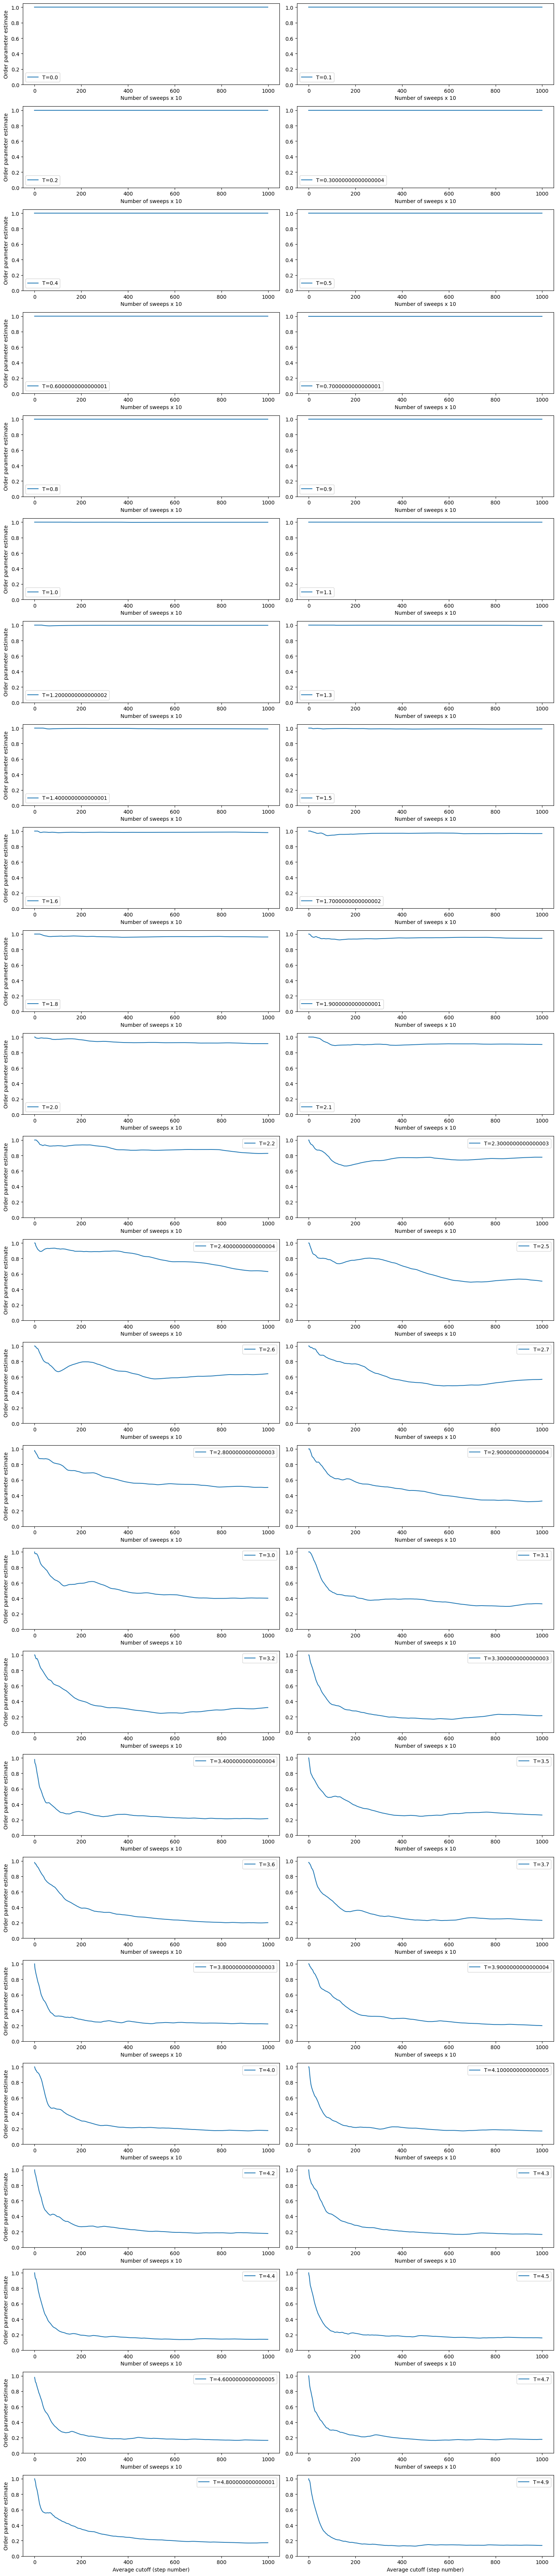

In [19]:
fig, axs = plt.subplots(25, 2, figsize=(15,69))
for i in range(25):
    axs[i,0].plot(averages[2*i], label=f"T={temperatures[2*i]}")
    axs[i,0].legend()
    axs[i,0].set_ylim([0.,1.05])
    axs[i,0].set_ylabel("Order parameter estimate")
    axs[i,0].set_xlabel("Number of sweeps x 10")
    axs[i,1].plot(averages[2*i+1], label=f"T={temperatures[2*i+1]}")
    axs[i,1].legend()
    axs[i,1].set_ylim([0.,1.05])
    axs[i,1].set_xlabel("Number of sweeps x 10")

axs[24,0].set_xlabel("Average cutoff (step number)");
axs[24,1].set_xlabel("Average cutoff (step number)");
plt.tight_layout()


### Interpretation:
Typically, you should find that a good choice is an x-axis value of 200, which corresponds to 20 sweeps.

However, we should have a closer look at the critical region, i.e. temperatures between 2.1 and 2.7

In [20]:
L = 10
dt = 0.1
num_updates = L*L*5000

sys = IsingMC_Metropolis(L)
temperatures = np.arange(2.1,2.7,dt)
data = []
for t in temperatures:
    mag_data = []
    sys.reset_spins()
    sys.set_temperature(t)
    for update in range(num_updates):
        sys.mrt_step()
        mag_data.append(np.abs(sys.M)/(sys.L*sys.L))
    data.append(mag_data)

In [21]:
print("Calculating averages...")
averages = []
count = 0
for dataset in data:
    current = []
    for i in range(1,len(dataset),500):
        current.append(np.mean(dataset[:i]))
    averages.append(np.array(current))
print("Done")

Calculating averages...
Done


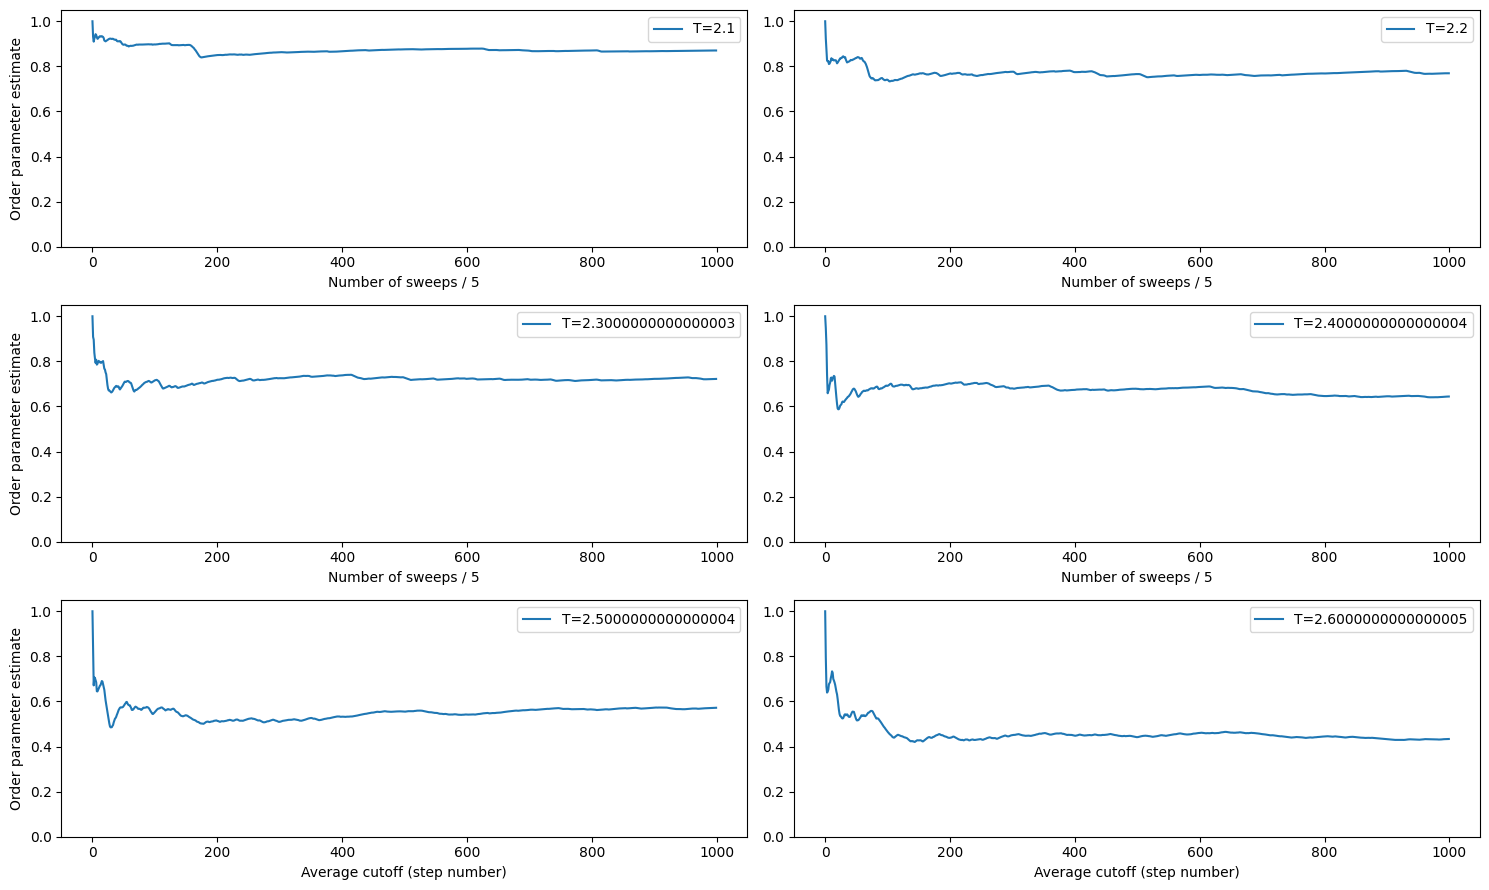

In [22]:
fig, axs = plt.subplots(3, 2, figsize=(15,9))
for i in range(3):
    axs[i,0].plot(averages[2*i], label=f"T={temperatures[2*i]}")
    axs[i,0].legend()
    axs[i,0].set_ylabel("Order parameter estimate")
    axs[i,0].set_ylim([0.,1.05])
    axs[i,0].set_xlabel("Number of sweeps / 5")
    axs[i,1].plot(averages[2*i+1], label=f"T={temperatures[2*i+1]}")
    axs[i,1].legend()
    axs[i,1].set_ylim([0.,1.05])
    axs[i,1].set_xlabel("Number of sweeps / 5")
axs[2,0].set_xlabel("Average cutoff (step number)");
axs[2,1].set_xlabel("Average cutoff (step number)");
plt.tight_layout()

### Interpretation:
Close to the critical region, you should find that the system needs a larger number of sweeps to relax (order of 1000).

## Step 2: Simulation
We use the above observations to run simulations at different temperatures and calculate the order parameter. We take 2^16 samples, so we can easily bin the data.

### Binning analysis utilities
First we write a function that will perform the binning analysis for us following the scheme in the exercise sheet.

In [23]:
def binning_step(data):
    ''' performs a single binning step
    
    Parameters
    ----------
    
    - data=[Q^(l-1)_1 ... Q^(l-1)_N]
      array of length N=2M, containing N measurements Q^(l-1)_i (e.g. magnetization m^(l-1)_i) 
      in the (l-1)'th level of the binning analysis
    
    
    Returns
    --------
    
    - new_data=[Q^(l)_1, ... Q^(l)_N]
      array of length M (lth level array of the binning analysis)
      
    - new_error: double
      error estimate of lth level of the binning analysis (eq. (6) in exercise sheet)
    
    '''
    average = np.mean(data)
    new_data = []
    for i in range(int(len(data)/2)):
        new_data.append((data[2*i]+data[2*i+1])/2.)
    new_error = 0.
    for d in new_data:
        new_error += (average - d)**2
    new_error = np.sqrt(new_error/(len(new_data)*(len(new_data)-1)))
    return new_data, new_error

#bin the data up to num_levels
def binning(data, num_levels):
    ''' bins the data up to num_level
     
    Parameters
    ----------
    
    - data=[Q_1 ... Q_N]:
      array of length N, containing N measurements Q_i (e.g. magnetization m_i) 
      
    - num_levels: int
      number of binning levels to be computed
      
      
    Returns
    -------
    
    - errors: array, dtype=double
      array of length num_levels+1, contains error estimates for each level
    
    
    '''
    errors = []
    #first, calculate the level-0 error
    average = np.mean(data)
    error = 0.
    for d in data:
        error += (average - d)**2
    error = np.sqrt(error/(len(data)*(len(data)-1)))
    errors.append(error)
    new_data = data
    for i in range(num_levels):
        new_data, new_error = binning_step(new_data)
        errors.append(new_error)
    return errors

### Simulation parameters
Now we define the parameters of our simulation. We'll use a very high number of samples and measure after each single-spin update. This highlights the properties of the Metropolis algorithm better. Typically you would perform a few uncorrelating updates between successive samples.

In [24]:
#temperatures at which we sample
#finer graining around the critical temperature; this is where the money is!
temps_low = np.arange(0.,2.1,0.1)
temps_crit = np.arange(2.1,2.7,0.02)
temps_high = np.arange(2.8,5.,0.1)
temperatures = np.concatenate((temps_low,temps_crit,temps_high))

#number of relaxation steps we want to perform
def relaxation_sweeps(temperature):
    if temperature < 2.1 or temperature > 2.7:
        return 20
    else:
        return 1000

#number of samples we take
num_samples = 2**20

#maximum binning level we consider
num_levels = 18

### Simulation
Apart from the order parameter, we also measure the actual magnetization, which should be zero for all temperatures. This takes several minutes to run. Implement here the Metropolis algorithm for each temperature including relaxation sweeps in order to equilibrate the system. After thermalization, collect the magnetization and the absolute value of the magnetization. Save the complete collection of the measurements in 
m_abs_data=[m_abs_data_T_1, ...m_abs_data_T_N], m_data=[m_data_T_1, ...m_data_T_N], where m_abs_data_T_i (m_data_T_i) correspond to the list of measurements taken for temperature T_i.

In [25]:
sys.reset_spins()

m_abs_data = []
m_data = []


for temperature in temperatures:
    print(f"temperature: {temperature:.2f}")
    # implement the algorithm here using the class instance sys
    
    
    sys.set_temperature(temperature)
    #relaxation
    rlx_sweeps = relaxation_sweeps(temperature)
    for rlx_step in range(rlx_sweeps):
        sys.mrt_sweep()
    #sampling
    m_abs_samples = []
    m_samples = []
    for smp_step in range(num_samples):
        sys.mrt_step()
        m_samples.append(sys.M/(sys.L**2))
        m_abs_samples.append(np.abs(sys.M)/(sys.L**2))
    m_abs_data.append(m_abs_samples)
    m_data.append(m_samples)

temperature: 0.00
temperature: 0.10
temperature: 0.20
temperature: 0.30
temperature: 0.40
temperature: 0.50
temperature: 0.60
temperature: 0.70
temperature: 0.80
temperature: 0.90
temperature: 1.00
temperature: 1.10
temperature: 1.20
temperature: 1.30
temperature: 1.40
temperature: 1.50
temperature: 1.60
temperature: 1.70
temperature: 1.80
temperature: 1.90
temperature: 2.00
temperature: 2.10
temperature: 2.12
temperature: 2.14
temperature: 2.16
temperature: 2.18
temperature: 2.20
temperature: 2.22
temperature: 2.24
temperature: 2.26
temperature: 2.28
temperature: 2.30
temperature: 2.32
temperature: 2.34
temperature: 2.36
temperature: 2.38
temperature: 2.40
temperature: 2.42
temperature: 2.44
temperature: 2.46
temperature: 2.48
temperature: 2.50
temperature: 2.52
temperature: 2.54
temperature: 2.56
temperature: 2.58
temperature: 2.60
temperature: 2.62
temperature: 2.64
temperature: 2.66
temperature: 2.68
temperature: 2.70
temperature: 2.80
temperature: 2.90
temperature: 3.00
temperatur

### Sanity check
Let's have a quick look at the order parameter to check if we get results in the same ballpark as our expectation.

Text(0, 0.5, 'Order Parameter')

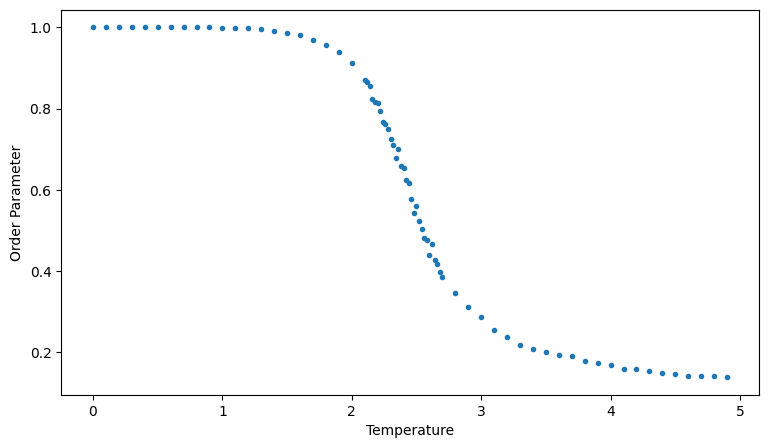

In [26]:
%matplotlib inline
ops = []
for opd in m_abs_data:
    ops.append(np.mean(opd))
fig= plt.figure(figsize=(9,5))
plt.plot(temperatures,ops,'.')
plt.xlabel("Temperature")
plt.ylabel("Order Parameter")

(-1.05, 1.05)

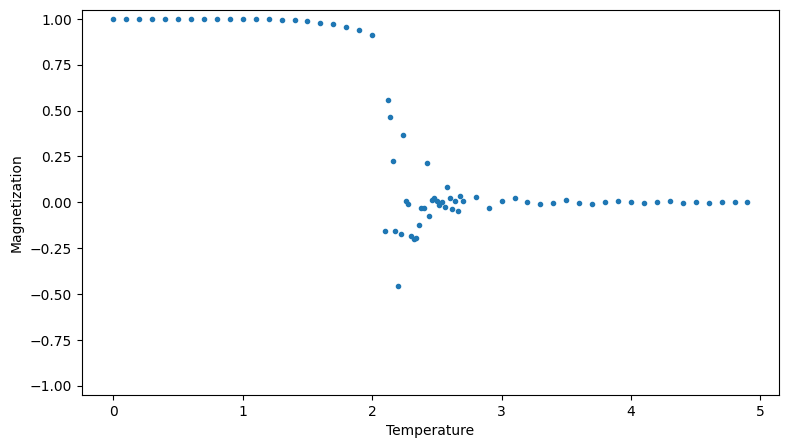

In [27]:
ms = []
for md in m_data:
    ms.append(np.mean(md))
fig= plt.figure(figsize=(9,5))
plt.plot(temperatures,ms,'.')
plt.xlabel("Temperature")
plt.ylabel("Magnetization")
plt.ylim([-1.05,1.05])

Looking at the magnetization as function of the temperature, you should find that the Metropolis algorithm is trapped in one sector of configuration space at low temperatures (it should be zero for all temperatures). Note that it always ends up in the states with all spins up due to the chosen initial state (you can try to change it to all spins down and see what changes). Even ridiculous amounts of sampling can't rectify this. This highlights the ginormous correlation time.

## Step 3: Binning Analysis

Here you use the binning utilities to study the behaviour of the errors vs the level of binning for different temperatures. This gives you an idea about the correlation time. Ideally, you should observe an exponential growth that slows into a plateau (bend the curve!). That's where the money is.\\
Note that the last few benning level may exhibit finite-size effects, as the number of samples approaches 1. In particular, problems arise close to the critical temperature, where the correlation time diverges.

[np.float64(0.00010046873492255422), np.float64(0.00014162383927420844), np.float64(0.00019935655030746762), np.float64(0.00027962449335592015), np.float64(0.00038941426471827257), np.float64(0.0005351022874214857), np.float64(0.0007175917007428008), np.float64(0.0009252249092072649), np.float64(0.0011333966596829223), np.float64(0.001283505386025969), np.float64(0.0013488998523426704), np.float64(0.0013618778238396643), np.float64(0.0014516085712076641), np.float64(0.0014434940426894306), np.float64(0.0014694263599122777), np.float64(0.0014236486681559815), np.float64(0.0012877542839252398), np.float64(0.0015959395282514827), np.float64(0.001761684788092553)]


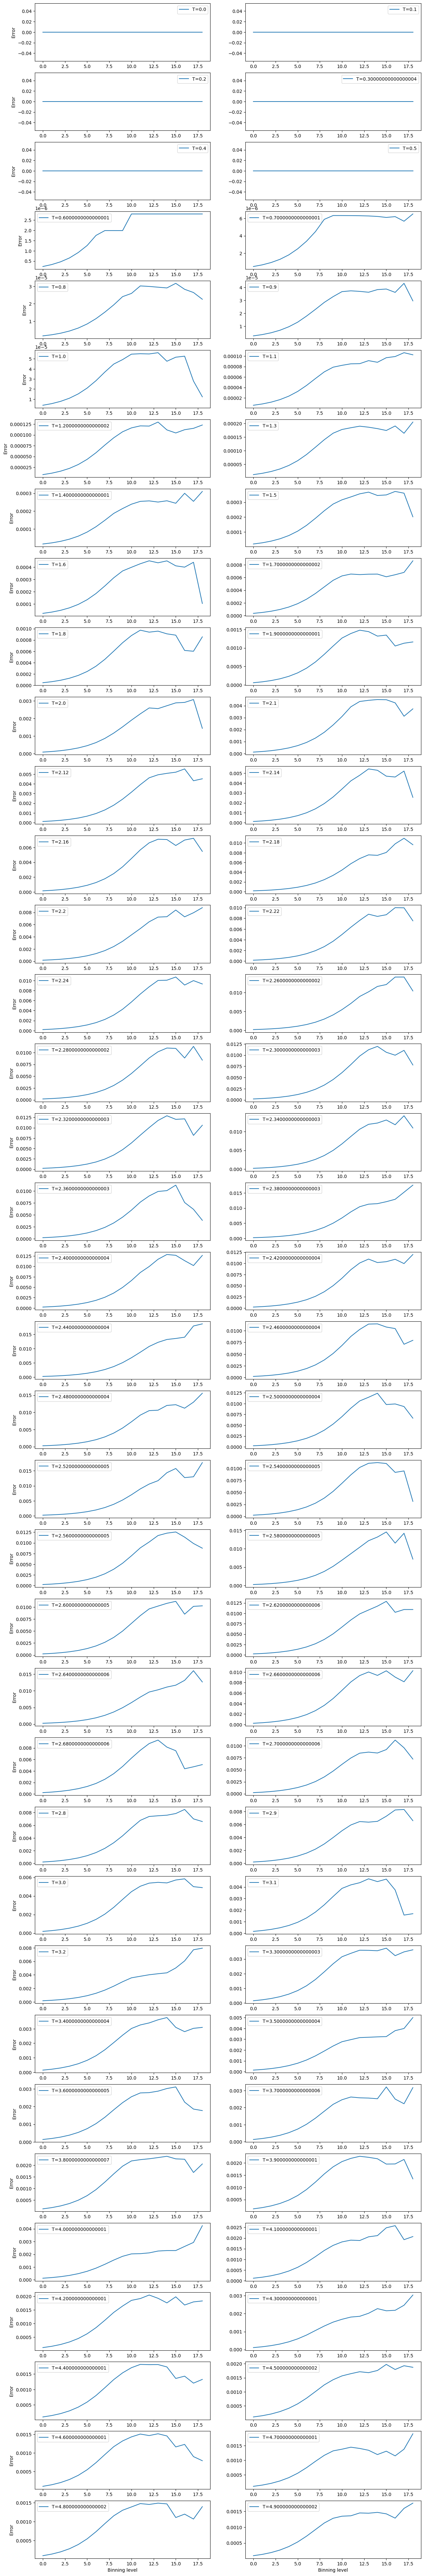

In [28]:
fig, axs = plt.subplots(int(len(temperatures)/2), 2, figsize=(15,100))
for i in range(int(len(temperatures)/2)):
    binning_data = binning(m_abs_data[2*i], num_levels)
    axs[i,0].plot(binning_data, label=f"T={temperatures[2*i]}")
    axs[i,0].legend()
    axs[i,0].set_ylabel("Error")
    binning_data = binning(m_abs_data[2*i+1], num_levels)
    axs[i,1].plot(binning_data, label=f"T={temperatures[2*i+1]}")
    axs[i,1].legend()
print(binning_data)
axs[int(len(temperatures)/2)-1,0].set_xlabel("Binning level");
axs[int(len(temperatures)/2)-1,1].set_xlabel("Binning level");

To extract the errors, we'll just use the maximum error observed while binning for each temperature. This should provide a rather good (slightly over) estimate for most temperatures.

In [29]:
errors = []
for i in range(len(m_abs_data)):
    binning_data = binning(m_abs_data[i], num_levels)
    errors.append(np.max(binning_data))
print(errors)

[np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(2.8038024902365963e-06), np.float64(6.5116614155288545e-06), np.float64(3.176068867990689e-05), np.float64(4.31994188374695e-05), np.float64(5.613261297748554e-05), np.float64(0.00010640639307267662), np.float64(0.00012960149677433098), np.float64(0.00020552641631532755), np.float64(0.00031031212584896854), np.float64(0.000372970462237166), np.float64(0.000450800463125564), np.float64(0.000864402727402783), np.float64(0.0009739842956974098), np.float64(0.001481430442089991), np.float64(0.003072478112169901), np.float64(0.0045103021398647854), np.float64(0.005538703629427506), np.float64(0.005426700742291895), np.float64(0.007232413963662154), np.float64(0.01097366668550302), np.float64(0.008776572710426832), np.float64(0.009997279371705548), np.float64(0.01071220448572187), np.float64(0.014097334748766364), np.float64(0.011293266196475193), np.float64(0.011936738369015654),

### Result

Text(0.5, 1.0, 'Ising simulation with the Metropolis algorithm')

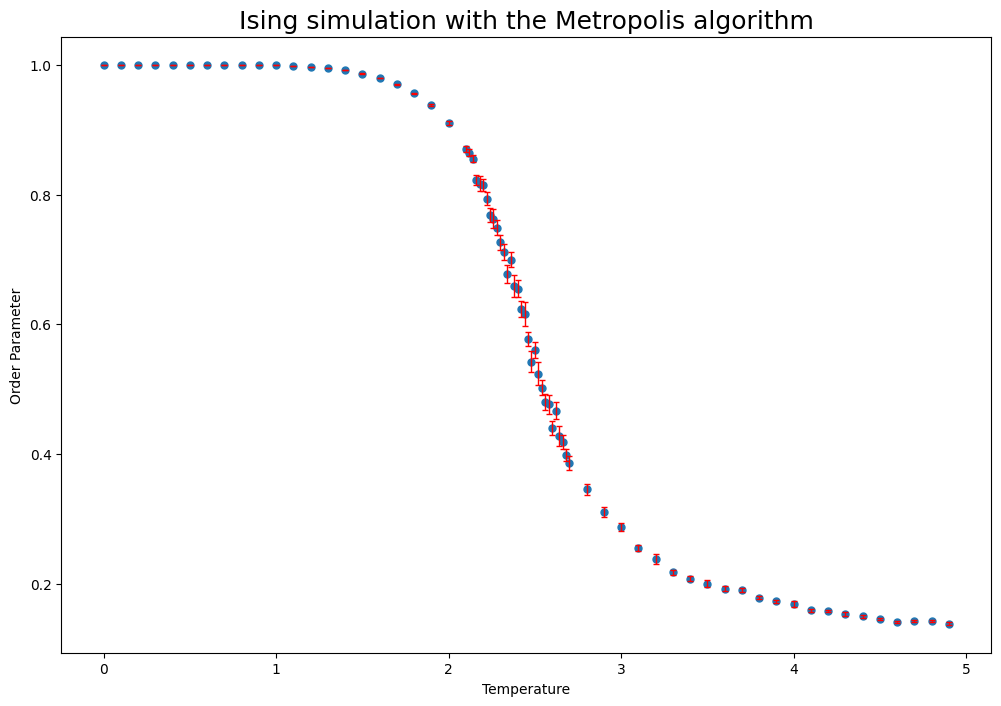

In [30]:
%matplotlib inline
fig, ax = plt.subplots(1, 1, figsize=(12,8))
ax.errorbar(temperatures,ops,yerr=errors, fmt='o', ms=5, ecolor='r', elinewidth=1, capsize=2, barsabove=True)
ax.set_xlabel("Temperature")
ax.set_ylabel("Order Parameter")
ax.set_title("Ising simulation with the Metropolis algorithm", fontsize=18)

# Exercise 2: Wolff cluster updates
We perform the same steps as in Exercise 1 with the Wolff algorithm. Each step of the Wolff algorithm consists of an iteration procedure to build a cluster of parallel spins with connected sites: At first, a random site $i$ is chosen to seed the cluster. Then, all neighbouring sites that have the same spin as the spin(s) in the cluster are added, each with probability $1-e^{-2\beta J}$. This is repeated until all boundaries of the cluster have been checked exactly once and no more sites are added. Then, the step is finished by flipping all spins of the cluster and thereby creating a new sample.
First of all, we write a class for the cluster updates.
In particular, we will need the following member functions:

- **update_probabilities**:
As in the Metropolis algorithm, we can reduce the computational cost by pre-computing the needed exponentials. Here, we only need to precompute one exponential $e^{-\beta J}$, which is saved in the member variable self.wolff_prob. Set the value of self.wolff_prob in **update_probabilities**.

- **set_temperature**:
(Re-)sets the temperature self.T (probability wolff_prob need to be updated when T is set or changed!) 

- **reset_spins**:
Sets the spins (array self.spins) to the initial configuration, which we here choose as all spins up. Keep in mind that we want to calculate the magnetization $\langle |m| \rangle=|1.0/L^2 \langle \sum_i s_i \rangle|$. For this, it is useful to keep track of the quantity $M=\sum_i s_i$ (member variable self.M) during the Metropolis algorithm. Set the initial value of $M$ in **reset_spins**.

- **wolff_step**: 
Performs one step of the wolff algorithm. Keep in mind to update self.M as well.

- **wolff_sweep**:
Performs one Monte Carlo sweep, consisting of $L*L$ steps.

*Hint (optional): It can be useful (with respect to the computational time) to store the indices of sites at the cluster boundaries with parallel spin using queue.Queue()*

In [52]:
class Index:
    '''utility class to make to wolff marginally more legible. holds an index pair. (Usage optionally) '''
    def __init__(self, i, j):
        self.i = i
        self.j = j
        
class IsingMC_Wolff:
    def __init__(self, length, temperature=0.):
        self.spins = np.ones((length,length),dtype=int)
        self.L = length
        self.T = temperature
        self.M = length * length #we start with all spins up
        self.wolff_prob = None
        self.wolff_marker = np.zeros((length,length),dtype=int) #container to mark which sites are in the cluster
        self.update_probabilities()
    
    def update_probabilities(self):
        '''we calculate the probability in the beginning so we don't have to recompute it'''
        if(self.T != 0.):
            #wolff acceptance probability
            self.wolff_prob = 1. - np.exp(-2./self.T)
           
        else:
            #wolff acceptance probability
            self.wolff_prob = 1.
            
    def set_temperature(self, temperature):
        '''set temperature and update the probability'''
        self.T = temperature
        self.update_probabilities()     
    
    
    def reset_spins(self):
        '''this resets the spins to the all-up state '''
        self.spins.fill(1)
        self.M = self.L * self.L

    
    #perform one update step using wolff
    def wolff_step(self):
        self.wolff_marker.fill(0) #clear cluster markers
        cl = [Index(random.randint(0,self.L-1),random.randint(0,self.L-1))] #cluster indices, could be optimized away
        s = self.spins[cl[0].i][cl[0].j] #value of the spin we're looking for
        self.wolff_marker[cl[0].i][cl[0].j] = 1 #mark that the seed is in the cluster
        q = queue.Queue() #queue of sites we have to consider
        #add neighbours of the seed to the queue
        q.put(Index((cl[0].i+1)%self.L, (cl[0].j)))
        q.put(Index((cl[0].i-1)%self.L, (cl[0].j)))
        q.put(Index((cl[0].i), (cl[0].j+1)%self.L))
        q.put(Index((cl[0].i), (cl[0].j-1)%self.L))
        while(not q.empty()):
            ind = q.get()
            if(self.spins[ind.i][ind.j] == s and self.wolff_marker[ind.i][ind.j] == 0): #not in there yet and correct spin
                if(random.random() < self.wolff_prob): #add to cluster with wolff probability
                    #add to cluster
                    cl.append(Index(ind.i,ind.j))
                    self.wolff_marker[ind.i][ind.j] = 1
                    #add neighbours that are not in cluster yet to consideration queue
                    if(self.wolff_marker[(ind.i+1)%self.L][ind.j] == 0):
                        q.put(Index((ind.i+1)%self.L,ind.j))
                    if(self.wolff_marker[(ind.i-1)%self.L][ind.j] == 0):
                        q.put(Index((ind.i-1)%self.L,ind.j))
                    if(self.wolff_marker[ind.i][(ind.j+1)%self.L] == 0):
                        q.put(Index(ind.i,(ind.j+1)%self.L))
                    if(self.wolff_marker[ind.i][(ind.j-1)%self.L] == 0):
                        q.put(Index(ind.i,(ind.j-1)%self.L))
        #now flip the cluster. this could be done on the fly.
        for ind in cl:
            self.spins[ind.i][ind.j] *= -1
        #update the magnetization
        self.M -= 2*len(cl)*s
    
    def wolff_sweep(self):
        '''perform an update sweep using wolff '''
        for i in range(self.L*self.L):
            self.wolff_step()

## Step 1: Relaxation analysis

In [53]:
L = 10
dt = 0.1
num_updates = L*L*10

sys = IsingMC_Wolff(L)
temperatures = np.arange(0.,5.0,dt)
data = []
for t in temperatures:
    mag_data = []
    sys.reset_spins()
    sys.set_temperature(t)
    for update in range(num_updates):
        sys.wolff_step()
        mag_data.append(np.abs(sys.M)/(sys.L*sys.L))
    data.append(mag_data)

In [54]:
print("Calculating averages...")
averages = []
count = 0
for dataset in data:
    current = []
    for i in range(1,len(dataset),10):
        current.append(np.mean(dataset[:i]))
    averages.append(np.array(current))
print("Done")

Calculating averages...
Done


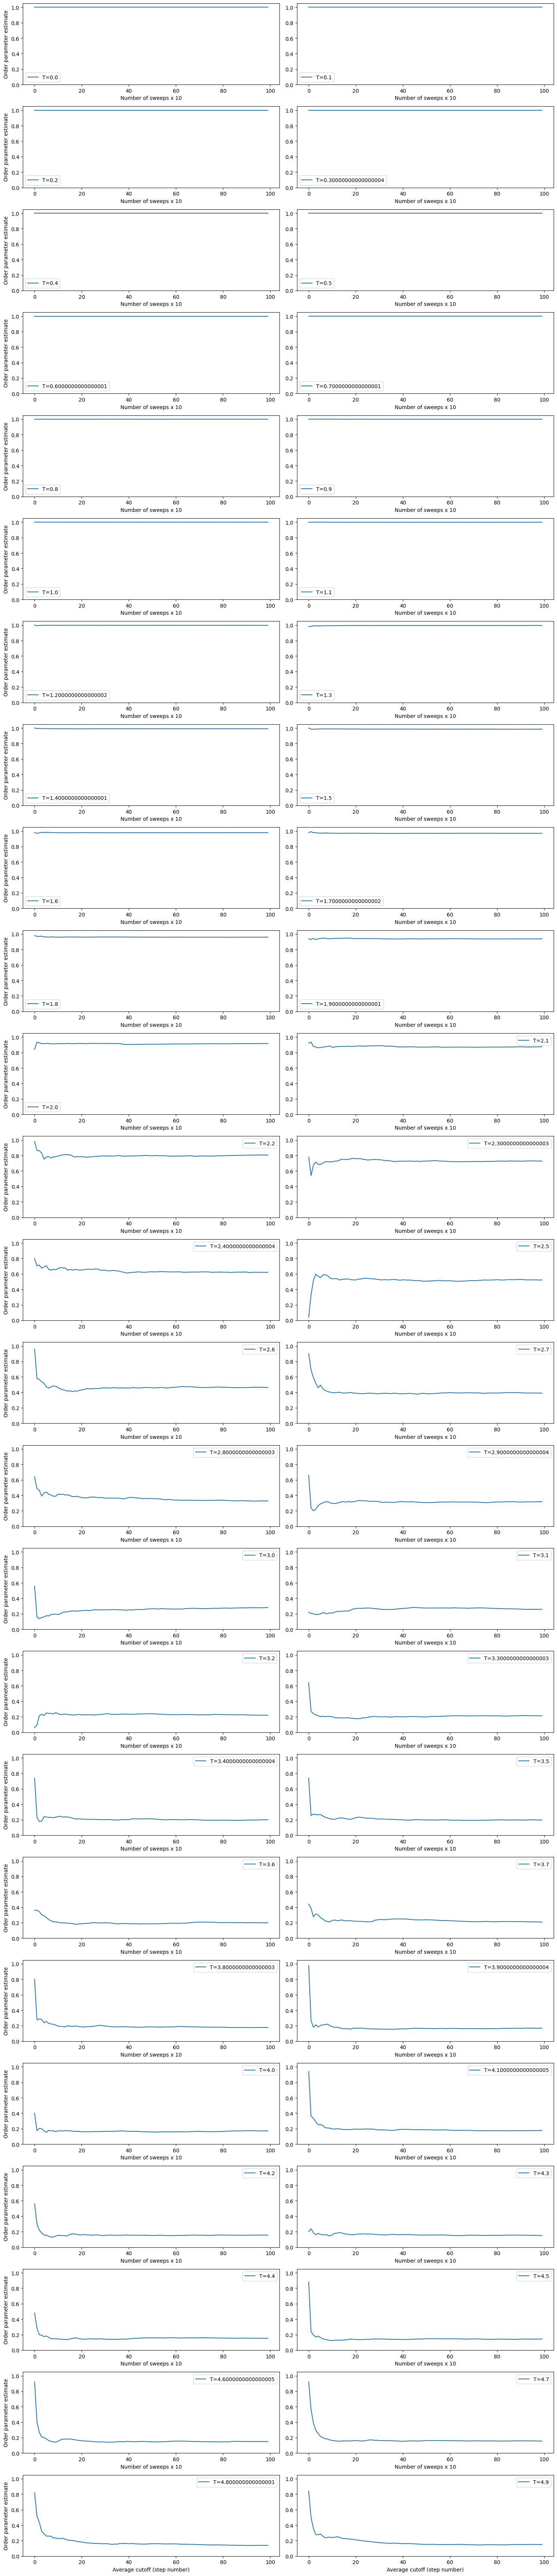

In [55]:
fig, axs = plt.subplots(25, 2, figsize=(15,69))
for i in range(25):
    axs[i,0].plot(averages[2*i], label=f"T={temperatures[2*i]}")
    axs[i,0].legend()
    axs[i,0].set_ylim([0.,1.05])
    axs[i,0].set_ylabel("Order parameter estimate")    
    axs[i,0].set_xlabel("Number of sweeps x 10")
    axs[i,1].plot(averages[2*i+1], label=f"T={temperatures[2*i+1]}")
    axs[i,1].legend()
    axs[i,1].set_ylim([0.,1.05])    
    axs[i,1].set_xlabel("Number of sweeps x 10")

axs[24,0].set_xlabel("Average cutoff (step number)");
axs[24,1].set_xlabel("Average cutoff (step number)");
plt.tight_layout()

### Interpretation
You should observe that, with the set parameters, after 150 steps we are typically well relaxed. For temperatures < 2, 30 steps seem to do the trick.

## Step 2: Simulation

### Parameters
Note that we take far fewer samples than with the Metropolis algorithm. However, we take different numbers of samples for different temperatures. We do this because the cluster sizes shrink as temperature rises.

We take many more samples than we actually need. I ran this with half the samples before, and still got better results than with the Metropolis algorithm. Hence if you don't feel like waiting longer than necessary, you can safely halve each num_samples, and lower the num_values by 1 each.

In [56]:
#temperatures at which we sample
#finer graining around the critical temperature; this is where the money is!
temps_low = np.arange(0.,2.1,0.1)
temps_crit = np.arange(2.1,2.7,0.02)
temps_high = np.arange(2.8,5.,0.1)
temperatures = np.concatenate((temps_low,temps_crit,temps_high))

#number of relaxation steps we want to perform
def relaxation_steps(temperature):
    if temperature < 2:
        return 30
    else:
        return 150

#we take an adaptive number of samples
#it takes some playing around to find out what makes sense at which temperature
#note that the cluster size goes down with rising temperature
def num_samples(temperature):
    if temperature < 1.3:
        return 2**9
    elif temperature < 2.4:
        return 2**13
    elif temperature < 3.:
        return 2**14
    else:
        return 2**15

#thus also the maximum binning levels need to be adaptive
def num_levels(temperature):
    if temperature < 1.3:
        return 8
    elif temperature < 2.4:
        return 11
    elif temperature < 3.:
        return 12
    else:
        return 13

### Simulation

Implement here the Wolff algorithm for each temperature including relaxation sweeps in order to equilibrate the system. After thermalization, collect the magnetization and the absolute value of the magnetization. Save the complete collection of the measurements of $|m|$ and $m$ in 
m_abs_data=[m_abs_data_T_1, ...m_abs_data_T_N], m_data=[m_data_T_1, ...m_data_T_N], where m_abs_data_T_i (m_data_T_i) correspond to the list of measurements taken for temperature T_i.

In [57]:
sys.reset_spins()

m_abs_data = []
m_data = []
for temperature in temperatures:
    print(f"temperature: {temperature}")
    #Implement the Wolff algorithm here using the instance sys of the class IsingMC_Wolff
    
    sys.set_temperature(temperature)
    #relaxation
    rlx_steps = relaxation_steps(temperature)
    for rlx_step in range(rlx_sweeps):
        sys.wolff_step()
    #sampling
    m_abs_samples = []
    m_samples = []
    sample_num = num_samples(temperature)
    for smp_step in range(sample_num):
        sys.wolff_step()
        m_samples.append(sys.M/(sys.L**2))
        m_abs_samples.append(np.abs(sys.M)/(sys.L**2))
    m_abs_data.append(m_abs_samples)
    m_data.append(m_samples)

temperature: 0.0
temperature: 0.1
temperature: 0.2
temperature: 0.30000000000000004
temperature: 0.4
temperature: 0.5
temperature: 0.6000000000000001
temperature: 0.7000000000000001
temperature: 0.8
temperature: 0.9
temperature: 1.0
temperature: 1.1
temperature: 1.2000000000000002
temperature: 1.3
temperature: 1.4000000000000001
temperature: 1.5
temperature: 1.6
temperature: 1.7000000000000002
temperature: 1.8
temperature: 1.9000000000000001
temperature: 2.0
temperature: 2.1
temperature: 2.12
temperature: 2.14
temperature: 2.16
temperature: 2.18
temperature: 2.2
temperature: 2.22
temperature: 2.24
temperature: 2.2600000000000002
temperature: 2.2800000000000002
temperature: 2.3000000000000003
temperature: 2.3200000000000003
temperature: 2.3400000000000003
temperature: 2.3600000000000003
temperature: 2.3800000000000003
temperature: 2.4000000000000004
temperature: 2.4200000000000004
temperature: 2.4400000000000004
temperature: 2.4600000000000004
temperature: 2.4800000000000004
temperature

### Sanity check

Text(0, 0.5, 'Order Parameter')

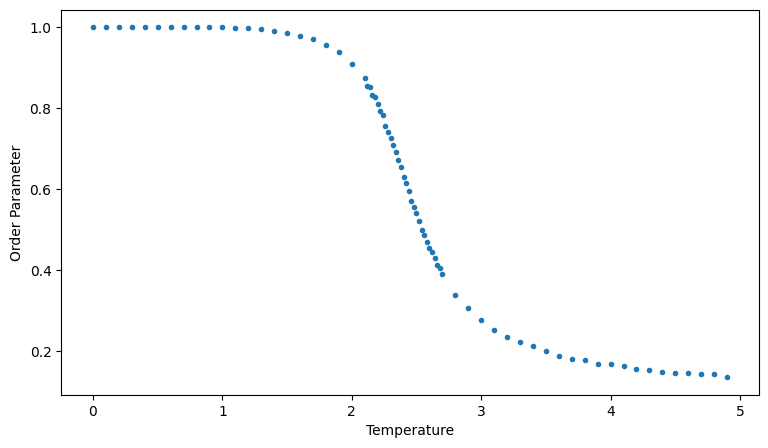

In [58]:
%matplotlib inline
ops = []
for opd in m_abs_data:
    ops.append(np.mean(opd))
fig= plt.figure(figsize=(9,5))
plt.plot(temperatures,ops,'.')
plt.xlabel("Temperature")
plt.ylabel("Order Parameter")

(-1.05, 1.05)

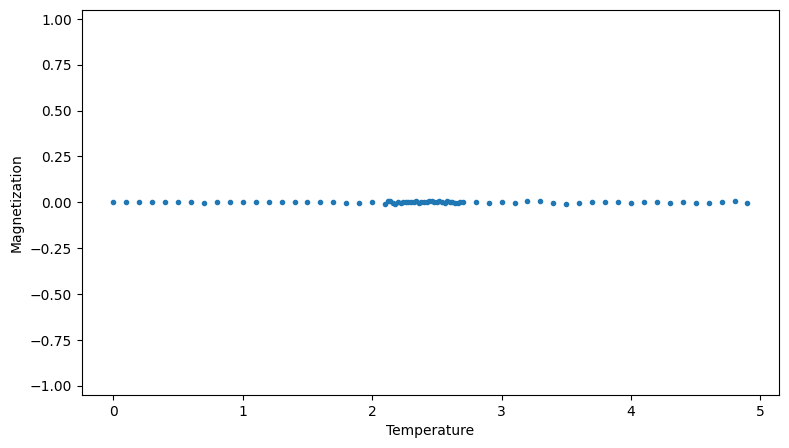

In [59]:
ms = []
for md in m_data:
    ms.append(np.mean(md))
fig= plt.figure(figsize=(9,5))
plt.plot(temperatures,ms,'.')
plt.xlabel("Temperature")
plt.ylabel("Magnetization")
plt.ylim([-1.05,1.05])

The magnetization shows that we are not stuck in one region of configuration space. The correlation time is drastically reduced.

## Step 3: Binning Analysis

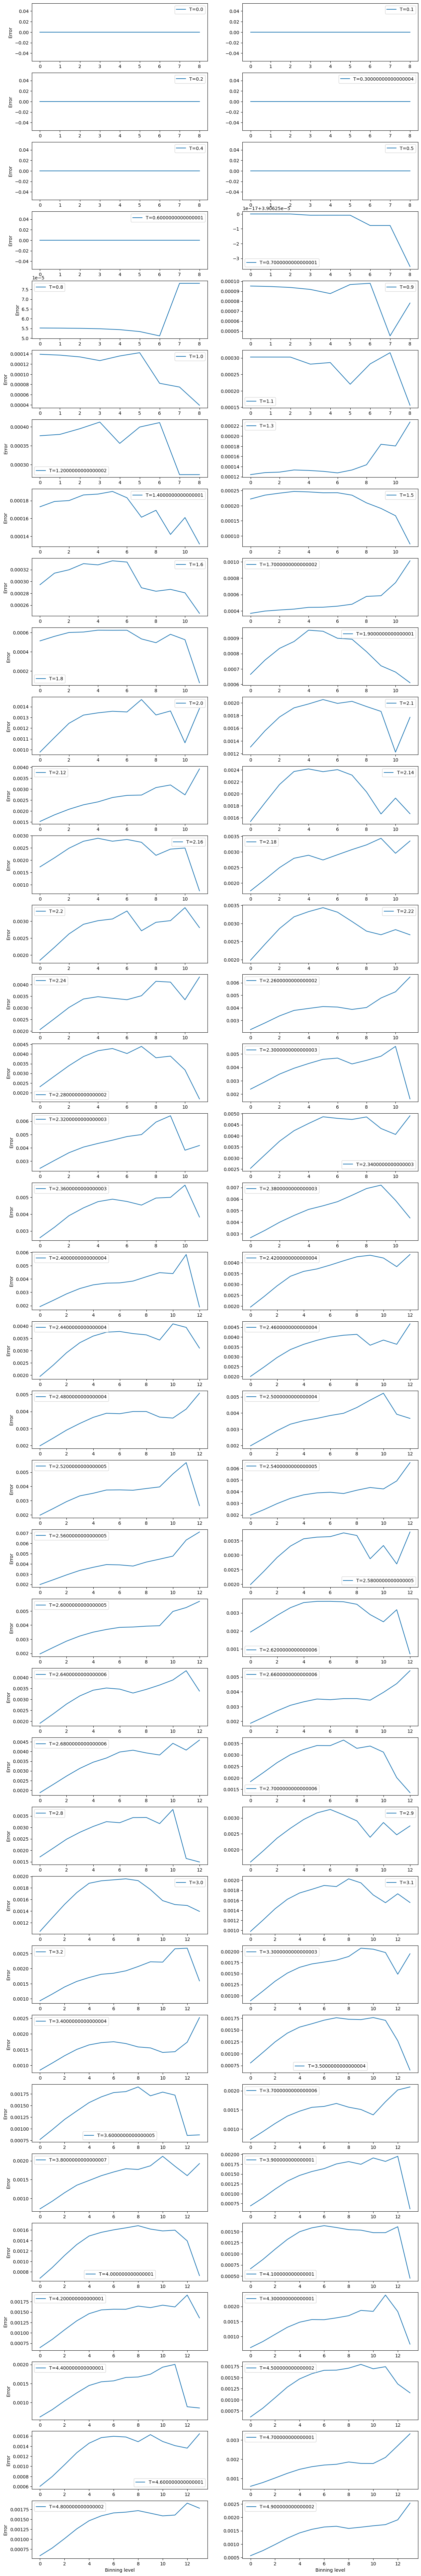

In [60]:
fig, axs = plt.subplots(int(len(temperatures)/2), 2, figsize=(15,100))
for i in range(int(len(temperatures)/2)):
    binning_data = binning(m_abs_data[2*i], num_levels(temperatures[2*i]))
    axs[i,0].plot(binning_data, label=f"T={temperatures[2*i]}")
    axs[i,0].legend()
    axs[i,0].set_ylabel("Error")
    binning_data = binning(m_abs_data[2*i+1], num_levels(temperatures[2*i+1]))
    axs[i,1].plot(binning_data, label=f"T={temperatures[2*i+1]}")
    axs[i,1].legend()
axs[int(len(temperatures)/2)-1,0].set_xlabel("Binning level");
axs[int(len(temperatures)/2)-1,1].set_xlabel("Binning level");

Almost all of these look converged. Note that we also get erratic behaviour due to finite size effects. We look for exponential growth that flattens. We see that these curves plateau much quicker than for M(RT)^2, highlighting again that the sampling is more efficient

In [61]:
errors = []
for i in range(len(m_abs_data)):
    binning_data = binning(m_abs_data[i], num_levels(temperatures[i]))
    errors.append(np.max(binning_data))
print(errors)

[np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(3.906250000000003e-05), np.float64(7.812499999998446e-05), np.float64(9.793487039499768e-05), np.float64(0.00014227904562132753), np.float64(0.0003157384284630916), np.float64(0.00041243080340431295), np.float64(0.0002275795743621002), np.float64(0.0001902859597553297), np.float64(0.0002469831123864223), np.float64(0.0003349479856403816), np.float64(0.0010116371701217887), np.float64(0.0006255787206208469), np.float64(0.0009523395509424058), np.float64(0.0014662390789537446), np.float64(0.0020502120965491654), np.float64(0.0039190045981315515), np.float64(0.0024172069912048646), np.float64(0.002893167877238393), np.float64(0.003434696267871432), np.float64(0.0034058537233956506), np.float64(0.003435002169131099), np.float64(0.004329129163391735), np.float64(0.006454408334829626), np.float64(0.004394708894237255), np.float64(0.005569739698837387), np.float64

### Result

Text(0.5, 1.0, 'Ising simulation with Wolff cluster updates')

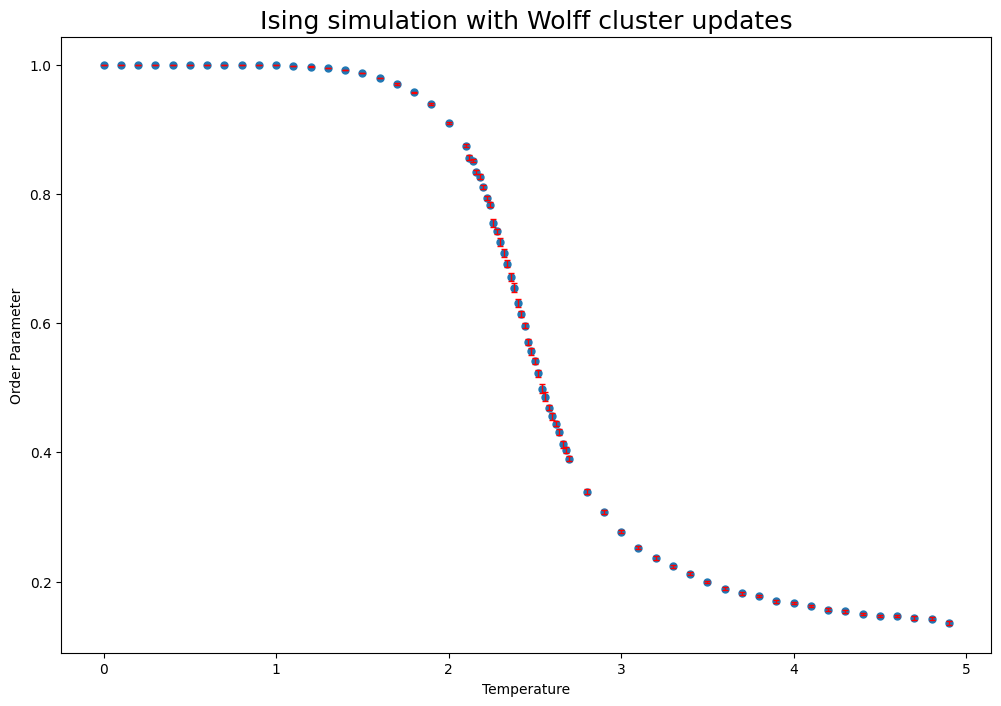

In [62]:
%matplotlib inline
fig, ax = plt.subplots(1, 1, figsize=(12,8))
ax.errorbar(temperatures,ops,yerr=errors, fmt='o', ms=5, ecolor='r', elinewidth=1, capsize=2, barsabove=True)
ax.set_xlabel("Temperature")
ax.set_ylabel("Order Parameter")
ax.set_title("Ising simulation with Wolff cluster updates", fontsize=18)

# Exercise 3: 2D Ising model on triangular lattice

In this exercise, you will build upon your existing implementation of the 2D square lattice Ising
model and adapt it to simulate the Ising model on a triangular lattice. Instead of starting from
scratch, you can exploit the capabilities of the large language model (ChatGPT) to guide you
through the necessary modifications.

## Step 1: identify the necessary changes
Due to the different geometry you would need to modify
- the lattice geometry;
- the nearest neighbor interactions;
- the implementation of the boundary conditions (we work with p.b.c like for the 2D square model).

You can ask ChatGPT to apply the necessary changes to your existing code.

Review the changes to be sure that they agree with your understanding.

## Step 2: simulation

Use the same utilities as for the square lattice case to run the simulations at different temperatures. Explore the range $T \in [0,5]$.
Before running the actual simulations identify the number of relaxation sweeps needed at each temperature. Consider that the expected critical temperature for the triangular Ising model is $3.641J/k_B$.

## Step 3: analysis

Plot the results for the magnetization as function of the temperature and roughly identify the critical temperature to check the correctness of the implementation. Is the value compatible with the expectation?

In [63]:
import numpy as np
import random

class IsingMC_Metropolis:
    def __init__(self, length, temperature=0.):
        self.spins = np.ones((length,length),dtype=int) # 2D array of spins, corresponds to the current configuration
        self.L = length
        self.T = temperature
        self.M = length * length # magnetization, we start with all spins up
        self.mrt_prob = None
        self.update_probabilities()

    def update_probabilities(self):
        '''Tabularize the probabilities using self.mrt_prob so we don't have to recompute them'''
        if self.T != 0.:
            # Ising acceptance probabilities
            # Access using the index 6 + s_i * h_i
            self.mrt_prob = np.array([np.exp(12. / self.T), 0., np.exp(8. / self.T), 0., np.exp(4. / self.T), 0., 1., 0.,
                                      np.exp(-4. / self.T), 0., np.exp(-8. / self.T), 0., np.exp(-12. / self.T)])
        else:
            # Ising acceptance probabilities
            # Access using the index s_i * h_i
            self.mrt_prob = np.array([1., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0.])

    def set_temperature(self, temperature):
        '''Set temperature and update the probabilities'''
        self.T = temperature
        self.update_probabilities()

    def reset_spins(self):
        '''Reset the spins to the all-up state'''
        self.spins.fill(1)
        self.M = self.L * self.L

    def mrt_step(self):
        '''Perform one update step using single spin Metropolis'''
        index1 = random.randint(0, self.L-1)
        index2 = random.randint(0, self.L-1)

        # Neighbors of triangular lattice with periodic boundary conditions
        # We have defined the triangular lattice as a square lattice with left diagonals in each "square", connecting the top left corner
        # of each square with the bottom right corner
        if index1 == self.L-1 and index2 == 0: # top right corner site
            neighbors = [((index1-1)%self.L, index2), ((index1+1)%self.L,index2), (index1, (index2+1)%self.L), (index1, (index2-1)%self.L),
                         (index1,index2),(index1,index2)]
        elif index1 == 0 and index2 == self.L-1: # bottom left corner site
            neighbors = [((index1-1)%self.L, index2), ((index1+1)%self.L,index2), (index1, (index2+1)%self.L), (index1, (index2-1)%self.L),
                         (index1,index2),(index1,index2)]
        elif index1 == 0 and index2 != self.L-1: # Top boundary excluding top right corner site
            neighbors = [((index1-1)%self.L, index2), ((index1+1)%self.L,index2), (index1, (index2+1)%self.L), (index1, (index2-1)%self.L),
                         (self.L-1-index2, self.L-1),((index1+1)%self.L, (index2+1)%self.L)]
        elif index1 != self.L-1 and index2 == 0: # Left boundary excluding bottom left corner site
            neighbors = [((index1-1)%self.L, index2), ((index1+1)%self.L,index2), (index1, (index2+1)%self.L), (index1, (index2-1)%self.L),
                         (self.L-1, self.L-1-index1),((index1+1)%self.L, (index2+1)%self.L)]
        elif index1 == self.L-1 and index2 > 0: # bottom boundary excluding bottom left corner site
            neighbors = [((index1-1)%self.L, index2), ((index1+1)%self.L,index2), (index1, (index2+1)%self.L), (index1, (index2-1)%self.L),
                         (index1-1, index2-1),(self.L-1-index2, 0)]
        elif index1 > 0 and index2 == self.L-1: # right boundary excluding top right corner site
            neighbors = [((index1-1)%self.L, index2), ((index1+1)%self.L,index2), (index1, (index2+1)%self.L), (index1, (index2-1)%self.L),
                         (index1-1, index2-1),(0, self.L-1-index1)]
        else: # ALL OTHER SITES (BULK SITES)
            neighbors = [((index1-1)%self.L, index2), ((index1+1)%self.L,index2), (index1, (index2+1)%self.L), (index1, (index2-1)%self.L),
                         (index1-1, index2-1),(index1+1, index2+1)]

        sihi = self.spins[index1][index2] * sum(self.spins[i][j] for i,j in neighbors)
        if self.mrt_prob[sihi + 6] > random.random():
            self.spins[index1][index2] *= -1  # flip
            self.M += 2. * self.spins[index1][index2]  # track magnetization

        ''' CHAT GPT CODE
        if index1 % 2 == 0:
            neighbors = [((index1-1)%self.L, index2), ((index1+1)%self.L, index2), (index1, (index2+1)%self.L), (index1, (index2-1)%self.L)]
        else:
            neighbors = [((index1-1)%self.L, index2), ((index1+1)%self.L, index2), (index1, (index2+1)%self.L), ((index1+1)%self.L, (index2-1)%self.L)]

        sihi = self.spins[index1][index2] * sum(self.spins[i][j] for i, j in neighbors)
        if self.mrt_prob[sihi + 4] > random.random():
            self.spins[index1][index2] *= -1  # flip
            self.M += 2. * self.spins[index1][index2]  # track magnetization
        '''

    def mrt_sweep(self):
        '''Perform an update sweep consisting of L*L steps using single spin Metropolis'''
        for i in range(self.L*self.L):
            self.mrt_step()



In [64]:
L = 20
dt = 0.1
num_updates = L * L * 200

sys = IsingMC_Metropolis(L)
temperatures = np.arange(1., 6.0, dt)
data = []
for t in temperatures:
    mag_data = []
    sys.reset_spins()
    sys.set_temperature(t)
    for update in range(num_updates):
        sys.mrt_step()
        mag_data.append(np.abs(sys.M) / (sys.L * sys.L))
    data.append(mag_data)

In [65]:
print("Calculating averages...")
averages = []
count = 0
for dataset in data:
    current = []
    for i in range(1,len(dataset),L*L):                 # we group the measurements in units of sweeps
        current.append(np.mean(dataset[:i]))
    averages.append(np.array(current))
print("Done")

Calculating averages...
Done


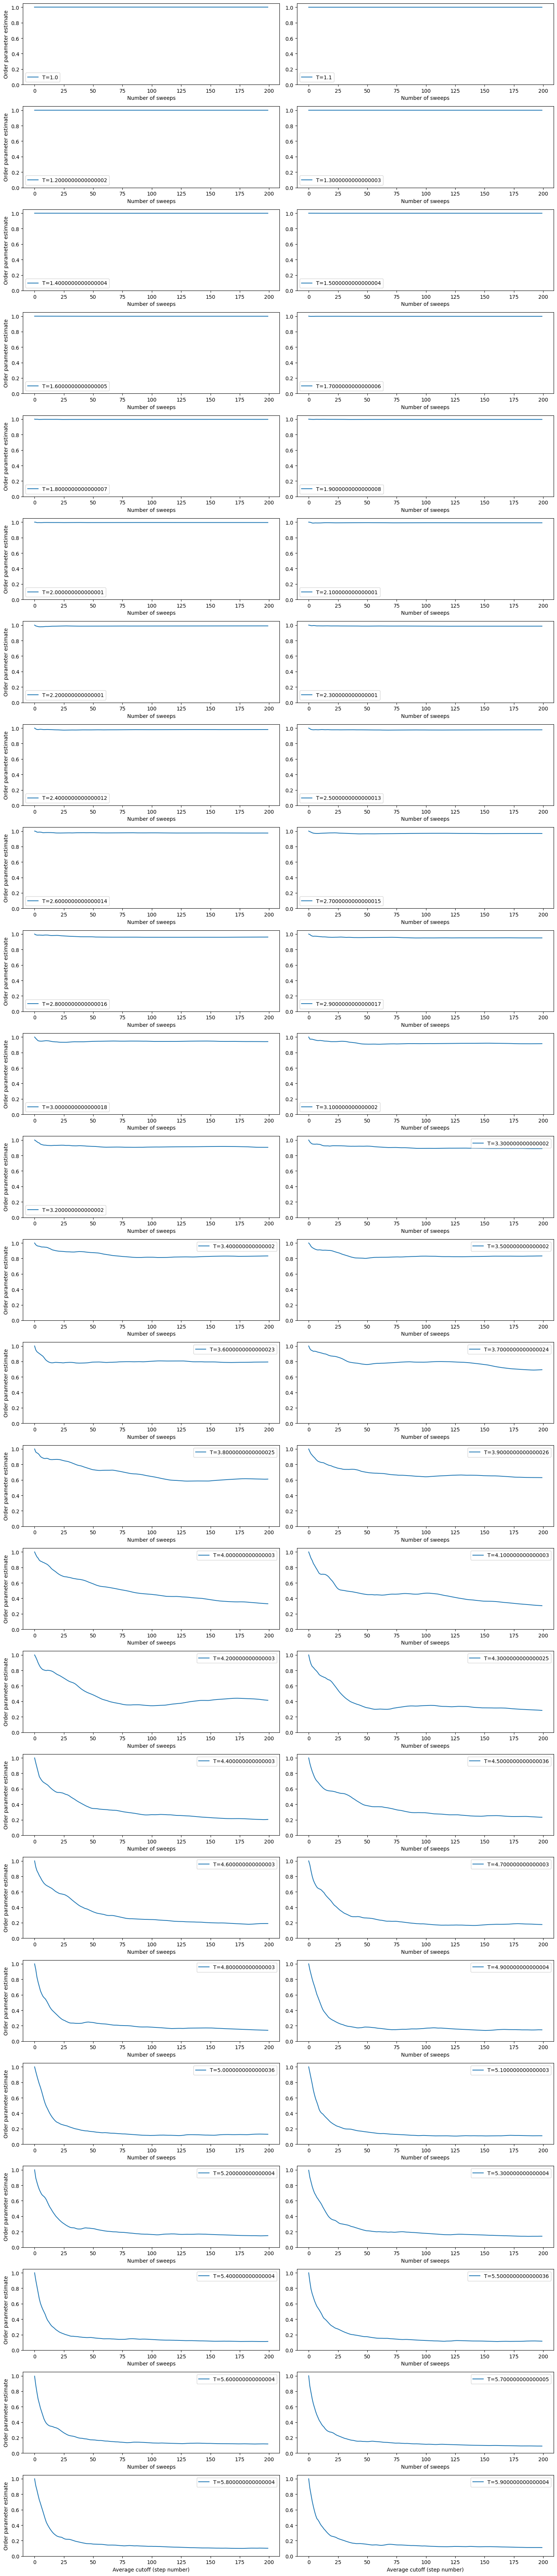

In [66]:
fig, axs = plt.subplots(25, 2, figsize=(15,69))
for i in range(25):
    axs[i,0].plot(averages[2*i], label=f"T={temperatures[2*i]}")
    axs[i,0].legend()
    axs[i,0].set_ylim([0.,1.05])
    axs[i,0].set_ylabel("Order parameter estimate")
    axs[i,0].set_xlabel("Number of sweeps")
    axs[i,1].plot(averages[2*i+1], label=f"T={temperatures[2*i+1]}")
    axs[i,1].legend()
    axs[i,1].set_ylim([0.,1.05])
    axs[i,1].set_xlabel("Number of sweeps")

axs[24,0].set_xlabel("Average cutoff (step number)");
axs[24,1].set_xlabel("Average cutoff (step number)");
plt.tight_layout()

In [67]:
L = 20
dt = 0.1
num_updates = L*L*1000

sys = IsingMC_Metropolis(L)
temperatures = np.arange(3.2,4.0,dt)
data = []
for t in temperatures:
    mag_data = []
    sys.reset_spins()
    sys.set_temperature(t)
    for update in range(num_updates):
        sys.mrt_step()
        mag_data.append(np.abs(sys.M)/(sys.L*sys.L))
    data.append(mag_data)

In [68]:
print("Calculating averages...")
averages = []
count = 0
for dataset in data:
    current = []
    for i in range(1,len(dataset),L*L):           # we group the measurements in units of sweeps
        current.append(np.mean(dataset[:i]))
    averages.append(np.array(current))
print("Done")

Calculating averages...
Done


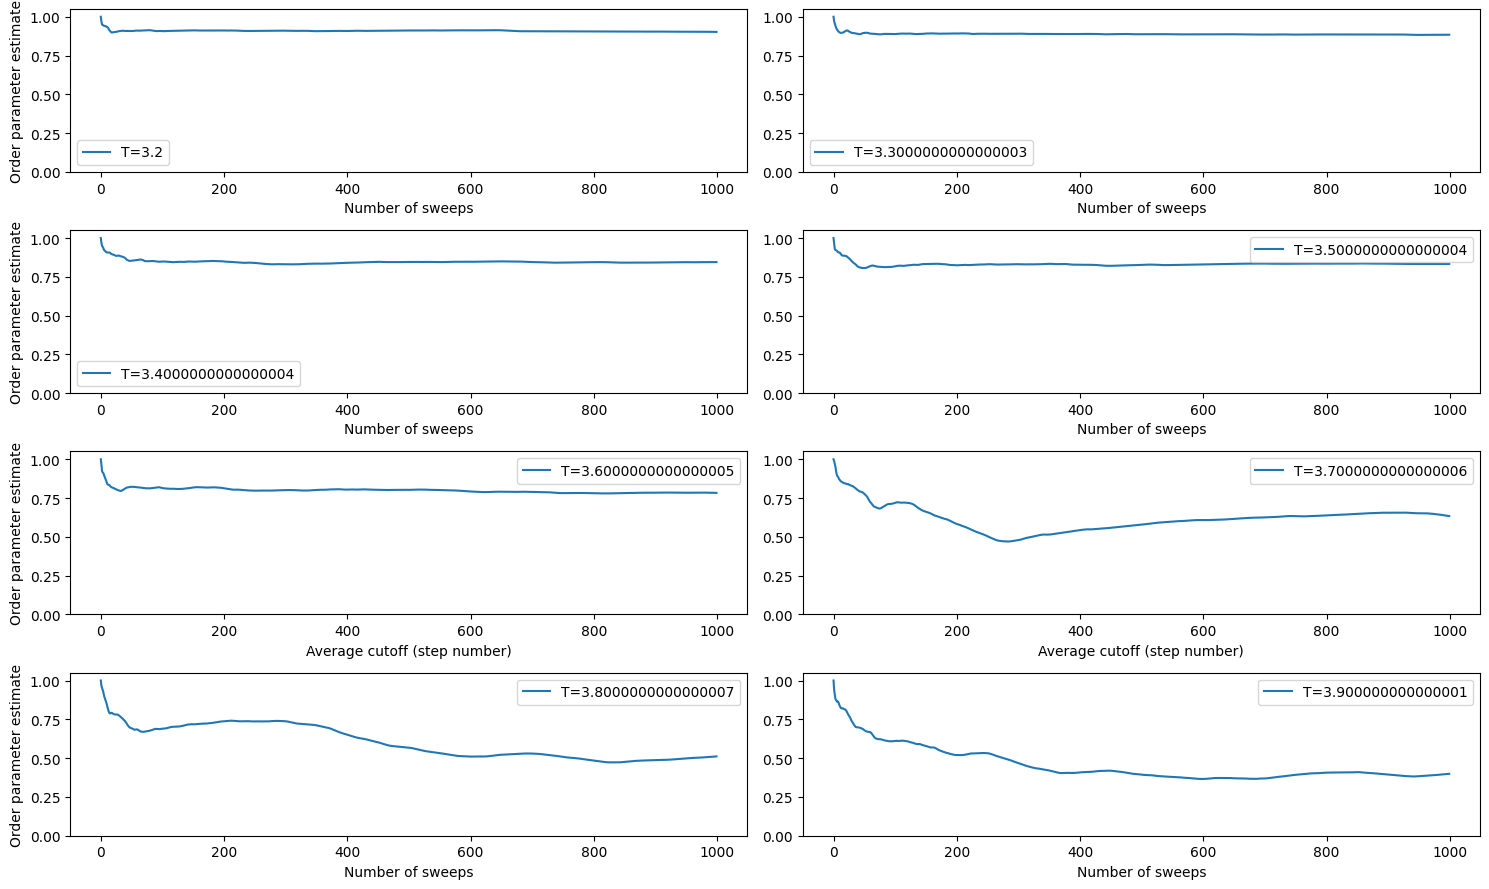

In [69]:
fig, axs = plt.subplots(4, 2, figsize=(15,9))
for i in range(4):
    axs[i,0].plot(averages[2*i], label=f"T={temperatures[2*i]}")
    axs[i,0].legend()
    axs[i,0].set_ylabel("Order parameter estimate")
    axs[i,0].set_ylim([0.,1.05])
    axs[i,0].set_xlabel("Number of sweeps")
    axs[i,1].plot(averages[2*i+1], label=f"T={temperatures[2*i+1]}")
    axs[i,1].legend()
    axs[i,1].set_ylim([0.,1.05])
    axs[i,1].set_xlabel("Number of sweeps")
axs[2,0].set_xlabel("Average cutoff (step number)");
axs[2,1].set_xlabel("Average cutoff (step number)");
plt.tight_layout()

In [70]:
#temperatures at which we sample
#finer graining around the critical temperature; this is where the money is!
temps_low = np.arange(1.0,3.2,0.1)
temps_crit = np.arange(3.2,4.0,0.02)
temps_high = np.arange(4.0,6.,0.1)
temperatures = np.concatenate((temps_low,temps_crit,temps_high))

#number of relaxation steps we want to perform (different for critical and non critical region)
def relaxation_sweeps(temperature):
    if temperature < 3.2 or temperature > 4.0:
        return 100
    else:
        return 500

#number of samples we take
num_samples = 2**16

In [71]:
sys.reset_spins()

m_abs_data = []
m_data = []


for temperature in temperatures:
    print(f"temperature: {temperature:.2f}")
    # implement the algorithm here using the class instance sys


    sys.set_temperature(temperature)
    #relaxation
    rlx_sweeps = relaxation_sweeps(temperature)
    for rlx_step in range(rlx_sweeps):
        sys.mrt_sweep()
    #sampling
    m_abs_samples = []
    m_samples = []
    for smp_step in range(num_samples):
        sys.mrt_step()
        m_samples.append(sys.M/(sys.L**2))
        m_abs_samples.append(np.abs(sys.M)/(sys.L**2))
    m_abs_data.append(m_abs_samples)
    m_data.append(m_samples)

temperature: 1.00
temperature: 1.10
temperature: 1.20
temperature: 1.30
temperature: 1.40
temperature: 1.50
temperature: 1.60
temperature: 1.70
temperature: 1.80
temperature: 1.90
temperature: 2.00
temperature: 2.10
temperature: 2.20
temperature: 2.30
temperature: 2.40
temperature: 2.50
temperature: 2.60
temperature: 2.70
temperature: 2.80
temperature: 2.90
temperature: 3.00
temperature: 3.10
temperature: 3.20
temperature: 3.22
temperature: 3.24
temperature: 3.26
temperature: 3.28
temperature: 3.30
temperature: 3.32
temperature: 3.34
temperature: 3.36
temperature: 3.38
temperature: 3.40
temperature: 3.42
temperature: 3.44
temperature: 3.46
temperature: 3.48
temperature: 3.50
temperature: 3.52
temperature: 3.54
temperature: 3.56
temperature: 3.58
temperature: 3.60
temperature: 3.62
temperature: 3.64
temperature: 3.66
temperature: 3.68
temperature: 3.70
temperature: 3.72
temperature: 3.74
temperature: 3.76
temperature: 3.78
temperature: 3.80
temperature: 3.82
temperature: 3.84
temperatur

Text(0, 0.5, 'Order Parameter')

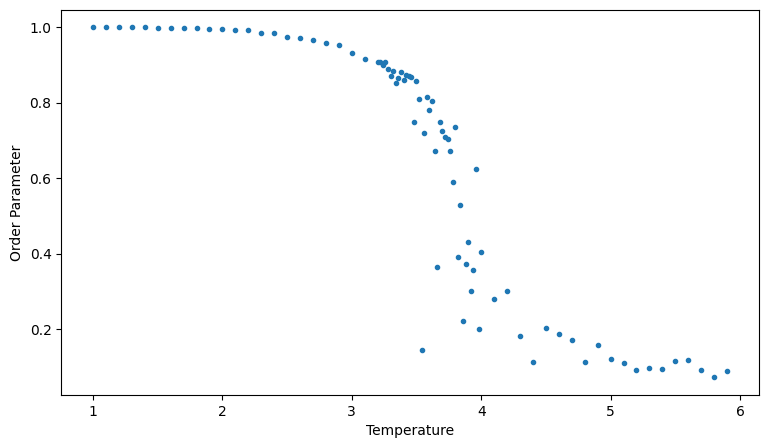

In [72]:
%matplotlib inline
ops = []
for opd in m_abs_data:
    ops.append(np.mean(opd))
fig= plt.figure(figsize=(9,5))
plt.plot(temperatures,ops,'.')
plt.xlabel("Temperature")
plt.ylabel("Order Parameter")

(-1.05, 1.05)

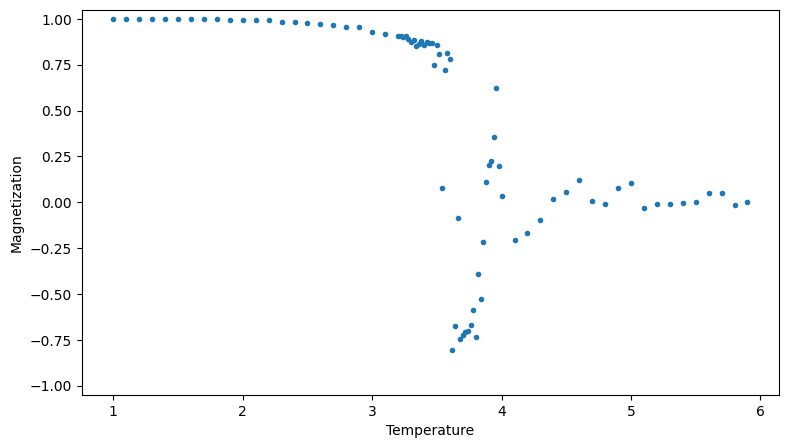

In [73]:
ms = []
for md in m_data:
    ms.append(np.mean(md))
fig= plt.figure(figsize=(9,5))
plt.plot(temperatures,ms,'.')
plt.xlabel("Temperature")
plt.ylabel("Magnetization")
plt.ylim([-1.05,1.05])